# Tutorial: end-to-end VQE molecular ground state energy simulation on the Rigetti Forest platform
In this python notebook tutorial, we present a basic introduction to using the Qu & Co VQE app for simulating the groundstate energy of an arbitrary molecule, on the Rigetti Forest quantum computing platform. In this tutorial, we show how to load a molecular problem Hamiltonian, how to configure the VQE instance and visualize the results from the calculations.

## Part 1: loading the chemistry problem
First, we must load the problem Hamiltonian of which we wish to find the ground state energy. The VQE app in principle can handle an arbitrary Hamiltonian, but for practical reasons we concentrate here on loading a molecular Hamiltonian via the opensource OpenFermion package. 
The MolecularData() object can be produced using different classical Self-Consistent Field packages, like PySCF, Psi4 etc. In this tutorial, we assume the user has generated a molecular data file in the .hdf5 format which he loads. We also show how to do this for the example case of PySCF, using OpenFermion-PySCF, in another tutorial. In principle you can therefore do end-to-end VQE if you install PySCF, OpenFermion-PySCF, OpenFermion and qucochemistry in the same environment!

In [13]:
%matplotlib notebook

import matplotlib.pyplot as plt

%autosave 30

Autosaving every 30 seconds


In [14]:
from openfermion import MolecularData

In [15]:
#filename = 'molecules/LiH_pyscf_1595.hdf5'
filename = 'molecules/H2_pyscf_equi.hdf5'
molecule = MolecularData(filename=filename)
print('Loaded molecule: ', molecule.name)
print('HF energy      : ' + str(molecule.hf_energy))
print('CCSD energy    : ' + str(molecule.ccsd_energy))
print('FCI energy     : ' + str(molecule.fci_energy))

Loaded molecule:  H2_sto-3g_singlet_pyscf
HF energy      : -1.1166843870853396
CCSD energy    : -1.137270340640917
FCI energy     : -1.1372701746609026


We in this example load the hydrogen molecule at equilibrium bond distance, and print the (stored) HF, CCSD and FCI energies found with classical SCF methods.
## Part 2: loading the VQE driver
Next, we load a new VQEexperiment() based on this molecule. We first show the default case with all options to their default values. For that, there is no need to set up a QVM yet, and it safely runs from within the comfort of your python environment.

In [16]:
from qucochemistry.vqe import VQEexperiment
vqe = VQEexperiment(molecule=molecule)

Next we query the qubit requirement and the exact groundstate energy. This energy is brute-force calculated from diagonalizing the Fermionic Hamiltonian which was loaded from the MolecularData object. In general this is computationally intractable but we can do this for a small molecule with limited number of basis functions. We can check that the result indeed is equal to machine precision with the FCI energy, as expected.

In [17]:
print('Number of qubits required to map the simulation problem: N = ', vqe.get_qubit_req())
exact_gs_E=vqe.get_exact_gs()
print('Exact diagonalization of molecular Hamiltonian yields  : E = ', exact_gs_E)

Number of qubits required to map the simulation problem: N =  4
Exact diagonalization of molecular Hamiltonian yields  : E =  -1.1372701746609015


Now that the VQE has been set up, we can simulate the VQE circuit output and evaluate the Hamiltonian estimation over this output. By default, the VQE has applied the following settings (for all details, please refer to the documentation):
 - circuit ansatz: Unitary Coupled Cluster method with Single and Double excitations (UCCSD). This is the unitary variant of the coupled cluster (CCSD) method which is typically included in the MolecularData() file. 
 - simulation method: Numpy - wavefunction simulator. This means the quantum circuit is simulated on a classical computer (the machine this notebook runs on). The full wavefunction is simulated and the algorithm has access it directly, which means the Hamiltonian operator estimation process is exact (no sampling). This is the most simple method for quickly testing the VQE; to run it on a real device, more settings need to be adjusted. We will show how to do this later in this tutorial.

If we now call the objective_function() method, the circuit is evaluted for a set of initial angles which are taken from the classical CCSD amplitudes in the MolecularData() file. This is a good first estimate of a circuit which prepares a state close to the groundstate. 

In [18]:
print('VQE objective function energy estimation: E = ', vqe.objective_function())

VQE objective function energy estimation: E =  -1.1372697939185201


We find an energy estimate which is better than the HF energy, but still worse than FCI and even CCSD. This is because the circuit angles have not yet been optimized. In the Variational Quantum Eigensolver (VQE) method, we optimize with a classical optmization algorithm over the Hamiltonian estimation energy, where the evaluation of the energy functional is performed on a quantum computer.
By default, the VQE is configured to run a classical optimizer with:
- optimization algorithm: BFGS (add optional keyword 'optimizer=Powell' etc to choose from the following list of available algorithms: {'Nelder-Mead', 'Powell', 'CG', 'BFGS', 'Newton-CG', 'L-BFGS-B ', 'TNC', 'COBYLA','SLSQP', 'trust-constr', 'dogleg', 'trust-ncg', 'trust-exact', 'trust-krylov'})
- max iterations: infinite (will not stop unless default convergence criteria are met) (set vqe.maxiter to any int. In this example, we set it to 3, but one can also define other convergence criteria manually.) 
- verbose_output: false (will supress optimizer debug print output). We in this example set this to True below:

In the example case where we loaded the LiH 12-qubit experiment, on a laptop this procedure will typically take a few minutes.

## Part 3: Running the VQE and analyzing results

In [19]:
# run VQE algorithm
vqe.verbose_output(True)
vqe.start_vqe(maxiter=4)
results=vqe.get_results()

Setting starting circuit parameters to initial amps:  [-1.9799336839741053e-16, -0.05677668069713777]
black-box function call #1
Energy estimate is now:  -1.1372697939185201
at angles:                [-1.9799336839741053e-16, -0.05677668069713777]
and this took 0.018 seconds to evaluate
black-box function call #2
Energy estimate is now:  -1.1372697939185201
at angles:                [1.4901160995854287e-08, -0.05677668069713777]
and this took 0.016 seconds to evaluate
black-box function call #3
Energy estimate is now:  -1.1372697939652892
at angles:                [-1.9799336839741053e-16, -0.05677666579597657]
and this took 0.014 seconds to evaluate
black-box function call #4
Energy estimate is now:  -1.137215925685621
at angles:                [-1.9799336839741053e-16, -0.05363806401603883]
and this took 0.016 seconds to evaluate
black-box function call #5
Energy estimate is now:  -1.137215925685621
at angles:                [1.4901160995854287e-08, -0.05363806401603883]
and this too

The results are now stored and we can analyze them

In [20]:
print('')
print('The optimized UCCSD circuit ansatz energy is:               E = '  + str(results.fun) + ' Hartree, at angles ' + str(results.x))
print('Energy error with exact GS, in units of chemical accuracy: dE = ' + str(abs(results.fun-exact_gs_E)/0.0016))



The optimized UCCSD circuit ansatz energy is:               E = -1.1372701746609009 Hartree, at angles [-1.97993368e-16 -5.65340697e-02]
Energy error with exact GS, in units of chemical accuracy: dE = 4.163336342344337e-13


Now, with the default values we initialized the <code class="markup--code markup--p-code">VQEexperiment()</code>   with, the Hamiltonian energy estimation is performed with full knowledge of the quantum wavefunction; however, in experiments we only have access to measurements of the qubits yielding 0 and 1. To simulate this, we will run the VQE on a QVM, a Quantum Virtual Machine.
On your local machine, install the Rigetti Forest SDK (detailed instructions [here](http://docs.rigetti.com/en/stable/start.html)) and run <code class="markup--code markup--p-code">QVM -S</code> and  <code class="markup--code markup--p-code"> quilc -R</code> in your terminal.
If you want to run your code on the QCS, please refer to [Rigetti's qcs page](https://www.rigetti.com/qcs/docs/intro-to-qcs).

As the QVM is more computationally intensive to run, we pick a small molecule like hydrogen to simulate in this example. With 4 spin-orbitals in the minimal STO-3G basis, we should first create a 4-qubit virtual quantum computer object and find a linear chain qubit lattice to run our UCCSD algorithm on (see [lattices](https://qcs.rigetti.com/lattices) for info on the lattice qubit ID's):

<IPython.core.display.Javascript object>


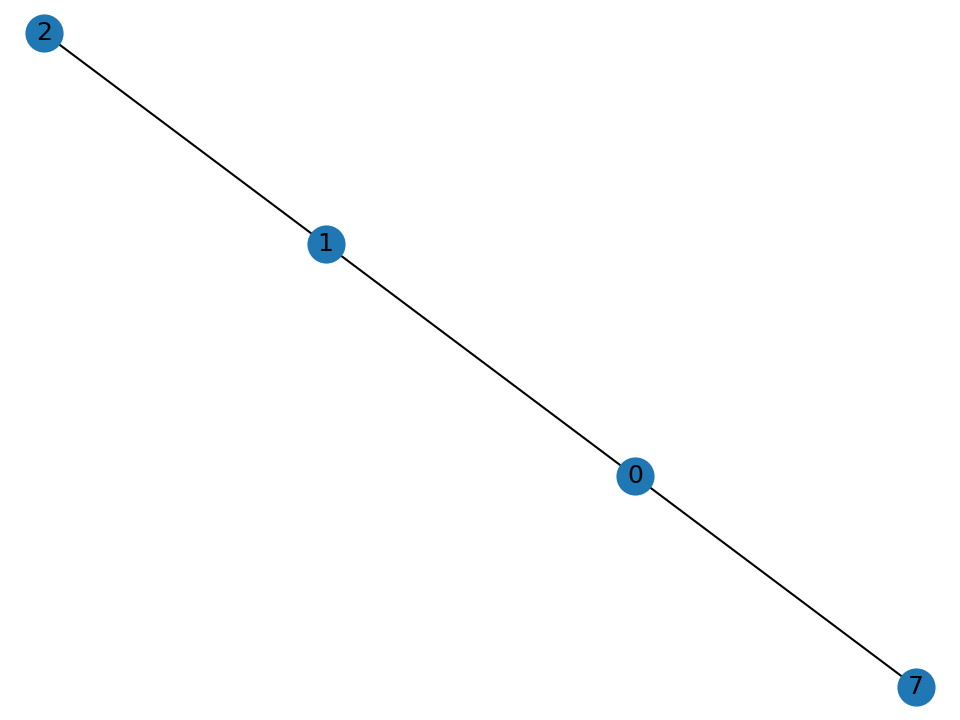

In [21]:
from networkx import draw, from_edgelist
filename = 'molecules/H2_pyscf_equi.hdf5'
molecule = MolecularData(filename=filename)

from pyquil.api import get_qc
from pyquil.device import NxDevice

qubits = [0, 1, 2, 7]
edges = [(0, 1), (1, 2),(0, 7)]
topo = from_edgelist(edges)
device = NxDevice(topo)

qc = get_qc('4q-qvm')
qc.device = device

draw(qc.device.topology, with_labels = True)
cq = [7,0,1,2] # lattice qubit ID"s in a serial string order

Next we configure a new vqe solver. We load the quantum computer object with <code class="markup--code markup--p-code">qc=qc</code>, adjust custom qubits with <code class="markup--code markup--p-code">custom_qubits=cq</code>, select the QuantumComputer method with <code class="markup--code markup--p-code">method = 'QC'</code>, set parametric and tomography options, and set the number of shots to <code class="markup--code markup--p-code">shotN=10000</code>

In [25]:
vqe = VQEexperiment(molecule=molecule, qc=qc, custom_qubits=cq, method = 'QC',
                    tomography = True, parametric = True, shotN=100000)

If we now run the objective function for the initial angles, which are again taken from CCSD pre-computations, we find

In [26]:
print('VQE objective function energy estimation using tomography with 100000 shots: E = ', vqe.objective_function())
exact_gs_E=vqe.get_exact_gs()
print('Exact diagonalization of molecular Hamiltonian yields  :                    E = ', exact_gs_E)

VQE objective function energy estimation using tomography with 100000 shots: E =  -1.137854094328228
Exact diagonalization of molecular Hamiltonian yields  :                    E =  -1.1372701746609015


Please note the finite sampling from the wavefunction using tomography, instead of exact Hamiltonian estimation one can only perform in a simulator not on a QPU.
This also poses a bigger challenge to the classical optimizer, as the optimizer function only has access to a stochastic drawing from a distribution instead of always returning exactly the mean upon repeated access. For example gradient estimation is then (much) less accurate and further research needs to be done to find the groundstate effectively.

One can also evaluate the objective function for the optimized angles we found before:

In [27]:
print('VQE objective function energy estimation using tomography with 100000 shots: E = ', vqe.objective_function(results.x))
exact_gs_E=vqe.get_exact_gs()
print('Exact diagonalization of molecular Hamiltonian yields  :                    E = ', exact_gs_E)

VQE objective function energy estimation using tomography with 100000 shots: E =  -1.1370445759038794
Exact diagonalization of molecular Hamiltonian yields  :                    E =  -1.1372701746609015
